In [1]:
import sys
sys.path.insert(1, '/home/jovyan')
import util
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PROJECT = 'gcp-wow-rwds-ai-mmm-super-dev'

In [2]:
SQL = '''
    WITH offer_table AS (
        SELECT 
            a.*,
            ROW_NUMBER() OVER(PARTITION BY crn ORDER BY campaign_start_date) rn
        FROM (
             SELECT DISTINCT 
                crn, 
                campaign_start_date, 
                offer_type,  
                campaign_length
             FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
        ) a
    ), 
    
    sankey_table AS (
        SELECT 
            a.campaign_start_date,
            a.crn,
            DATE_DIFF(b.campaign_start_date, a.campaign_start_date, day) AS days_lapsed,
            a.campaign_length,
            a.offer_type,
            b.offer_type AS offer_type_next
        FROM 
            offer_table a 
            LEFT JOIN offer_table b 
                ON a.crn = b.crn AND a.rn = (b.rn - 1)
         WHERE a.campaign_start_date <= '2021-04-30' -- this is to disregard the last few execution where rollover is unknown
    ), 
    
    rollover_table AS (
        SELECT
            campaign_start_date,
            crn,
            offer_type,
            CASE 
                WHEN days_lapsed IS NULL THEN 0
                WHEN days_lapsed > campaign_length THEN 0
                ELSE 1
            END AS rollover_flag
        FROM sankey_table
    ), 
    
    redeemer_table AS (
        SELECT 
            campaign_start_date, 
            crn, 
            offer_type,
            MAX(redeem_flag) AS redeem
        FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
        GROUP BY 1,2,3
        HAVING redeem = 1
    ), 
    
    spend_table AS (

        SELECT 
            campaign_start_date, 
            crn, 
            offer_type, 
            post_week_flag,
            AVG(as_weekly_spd) AS as_weekly_spd
        FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE` 
        GROUP BY 1,2,3,4

    ), 
    
    core_table AS (
        SELECT 
            CASE WHEN rdm.crn IS NULL THEN 0 ELSE 1 END redeem_flag,
            rol.rollover_flag,
            spd.offer_type,
            spd.post_week_flag,
            spd.as_weekly_spd
        FROM spend_table spd
            JOIN rollover_table rol 
                ON rol.campaign_start_date = spd.campaign_start_date AND rol.crn = spd.crn AND rol.offer_type = spd.offer_type
            LEFT JOIN redeemer_table rdm
                ON rdm.campaign_start_date = spd.campaign_start_date AND rdm.crn = spd.crn AND rdm.offer_type = spd.offer_type
    ) 

    SELECT 
        offer_type,
        rollover_flag,
        redeem_flag,
        post_week_flag,
        AVG(as_weekly_spd) AS as_weekly_spd,
        COUNT(1) AS n
    FROM core_table
    GROUP BY 1,2,3,4
    ORDER BY 1,2,3,4;
'''

In [3]:
df = util.sql2df(PROJECT, SQL)
df['as_weekly_spd_n'] = df['as_weekly_spd'] * df['n']
df.head(10)

offer_type  rollover_flag  redeem_flag  post_week_flag  as_weekly_spd  \
0         2C              0            0               0      68.995405   
1         2C              0            0               1      69.114022   
2         2C              0            1               0     218.251657   
3         2C              0            1               1     123.704401   
4         2C              1            0               0      65.047216   
5         2C              1            0               1      65.780695   
6         2C              1            1               0     208.828981   
7         2C              1            1               1     133.362817   
8         4C              0            0               0      49.696086   
9         4C              0            0               1      49.455250   

         n  as_weekly_spd_n  
0  2588322     1.785823e+08  
1  2588322     1.788893e+08  
2    81753     1.784273e+07  
3    81753     1.011321e+07  
4  6435414     4.186058e+08  
5  6435414     4.233260e+08  
6   166645     3.480031e+07  
7   166645     2.222425e+07  
8  2219996     1.103251e+08  
9  2219996     1.097905e+08

In [4]:
def draw(labels, flag_0, flag_1):
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(15,5))
    rects1 = ax.bar(x - width/2, flag_0, width, label='Promo')
    rects2 = ax.bar(x + width/2, flag_1, width, label='Post')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('as_weekly_spd')
    ax.set_title('Average weekly spend by offer type')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3, fmt='%.1f')
    ax.bar_label(rects2, padding=3, fmt='%.1f')

    fig.tight_layout()

    plt.show()

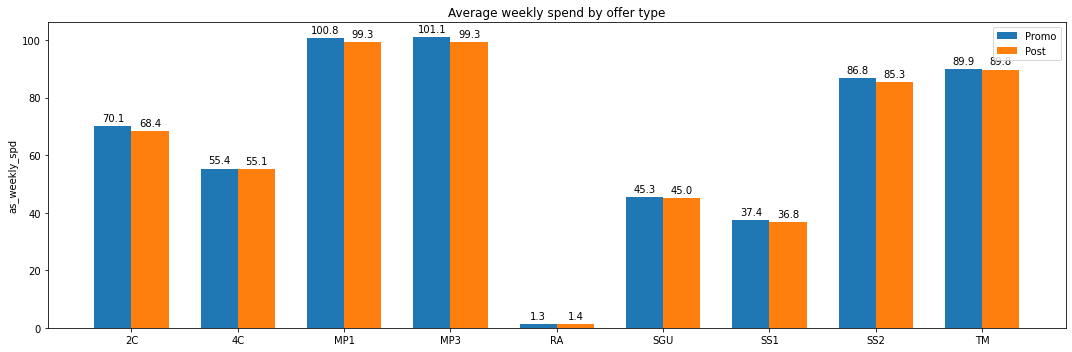

In [5]:
df_agg = df.groupby(['offer_type', 'post_week_flag']).agg({'n': 'sum', 'as_weekly_spd_n': 'sum'}).reset_index()
df_agg['as_weekly_spd'] = df_agg['as_weekly_spd_n'] / df_agg['n'] 
df_agg.drop(columns=['n','as_weekly_spd_n'], inplace=True)

labels = list(df_agg['offer_type'].unique())
flag_0 = list(df_agg[df_agg['post_week_flag']==0]['as_weekly_spd'])
flag_1 = list(df_agg[df_agg['post_week_flag']==1]['as_weekly_spd'])

draw(labels, flag_0, flag_1)

Redeem = 0


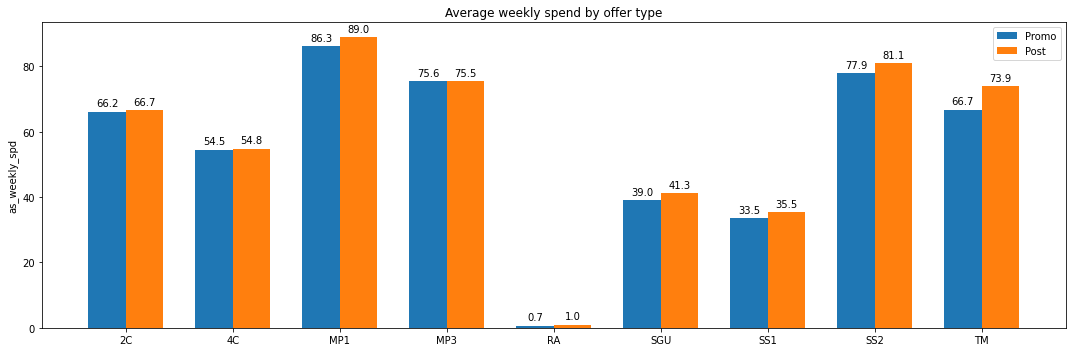

Redeem = 1


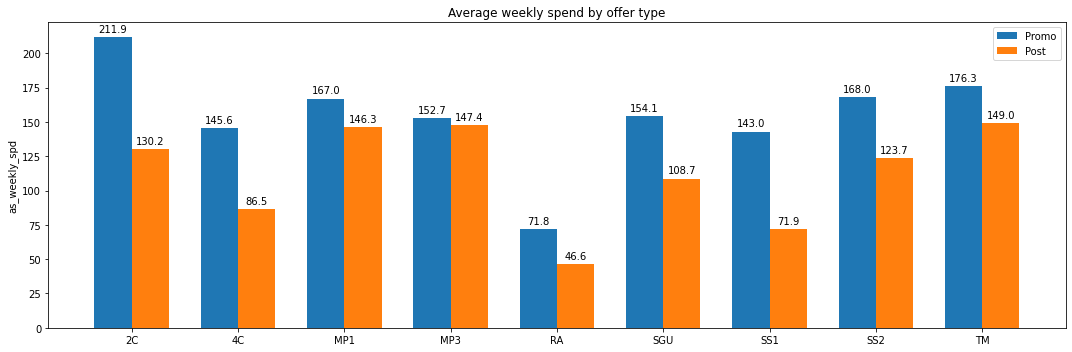

In [6]:
for i in range(2):
    print('='*150)
    print(f'Redeem = {i}')
    print('='*150)
    df_agg = df[df['redeem_flag'] == i].groupby(['offer_type', 'post_week_flag']).agg({'n': 'sum', 'as_weekly_spd_n': 'sum'}).reset_index()
    df_agg['as_weekly_spd'] = df_agg['as_weekly_spd_n'] / df_agg['n'] 
    df_agg.drop(columns=['n','as_weekly_spd_n'], inplace=True)

    labels = list(df_agg['offer_type'].unique())
    flag_0 = list(df_agg[df_agg['post_week_flag']==0]['as_weekly_spd'])
    flag_1 = list(df_agg[df_agg['post_week_flag']==1]['as_weekly_spd'])

    draw(labels, flag_0, flag_1)



Redeem = 0
               Rollover = 0


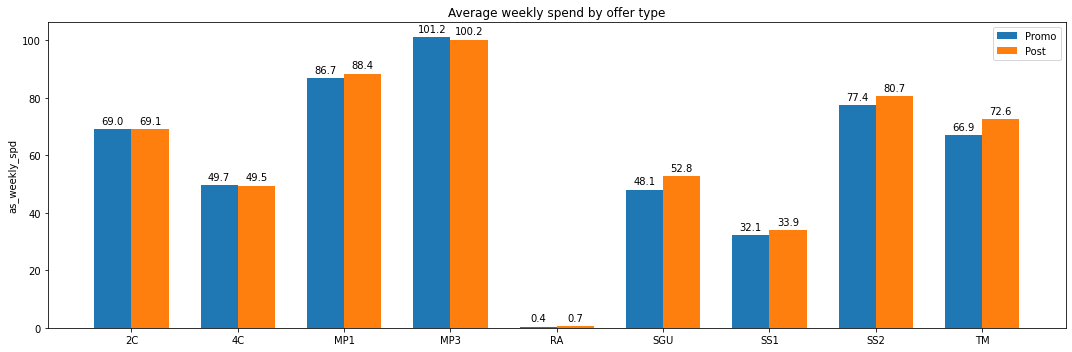

               Rollover = 1


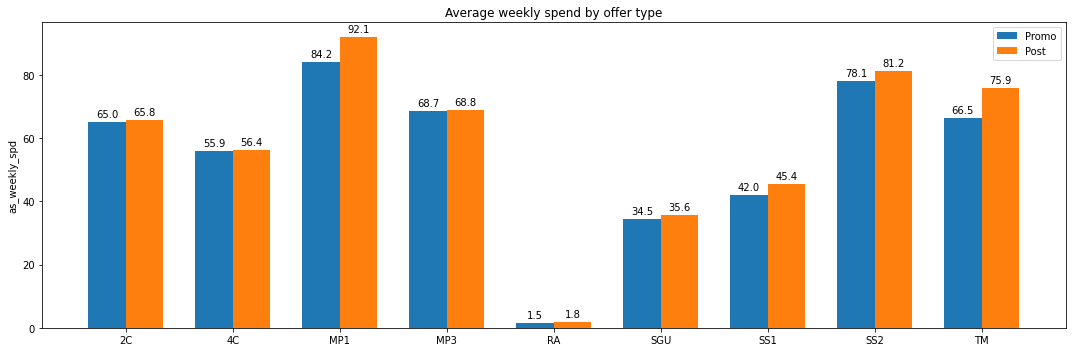

Redeem = 1
               Rollover = 0


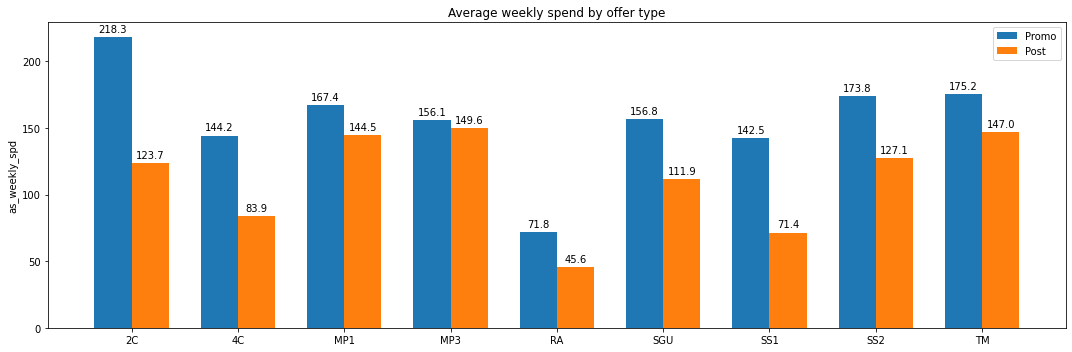

               Rollover = 1


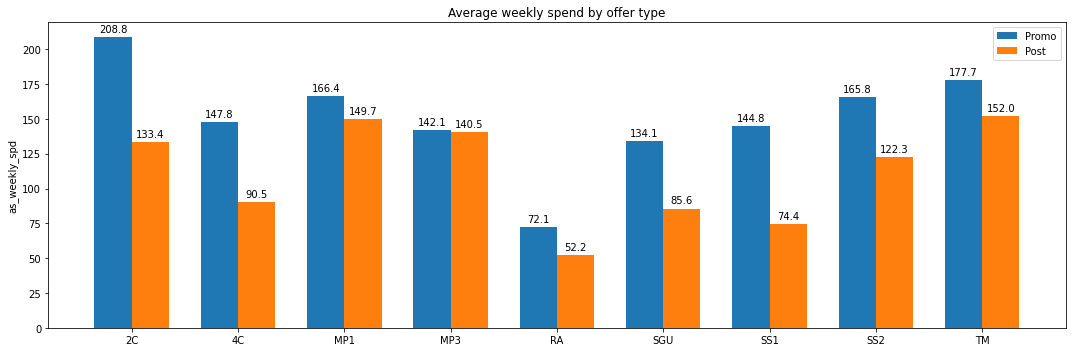

In [7]:
for i in range(2):
    print('='*150)
    print(f'Redeem = {i}')
    print('='*150)
    for j in range(2):
        print(' '*15+'='*135)
        print(' '*15+f'Rollover = {j}')
        print(' '*15+'='*135)
        df_agg = df[(df['redeem_flag'] == i)&(df['rollover_flag'] == j)].groupby(['offer_type', 'post_week_flag']).agg({'n': 'sum', 'as_weekly_spd_n': 'sum'}).reset_index()
        df_agg['as_weekly_spd'] = df_agg['as_weekly_spd_n'] / df_agg['n'] 
        df_agg.drop(columns=['n','as_weekly_spd_n'], inplace=True)

        labels = list(df_agg['offer_type'].unique())
        flag_0 = list(df_agg[df_agg['post_week_flag']==0]['as_weekly_spd'])
        flag_1 = list(df_agg[df_agg['post_week_flag']==1]['as_weekly_spd'])

        draw(labels, flag_0, flag_1)

In [8]:
df_agg = df[(df['redeem_flag'] == 1)].groupby(['rollover_flag', 'post_week_flag']).agg({'n': 'sum', 'as_weekly_spd_n': 'sum'}).reset_index()
df_agg['as_weekly_spd'] = df_agg['as_weekly_spd_n'] / df_agg['n'] 
df_agg.drop(columns=['n','as_weekly_spd_n'], inplace=True)
df_agg

rollover_flag  post_week_flag  as_weekly_spd
0              0               0     163.129848
1              0               1     133.047577
2              1               0     165.696592
3              1               1     135.661758

In [21]:
SQL = '''
    WITH offer_table AS (
        SELECT 
            a.*,
            ROW_NUMBER() OVER(PARTITION BY crn ORDER BY campaign_start_date) rn
        FROM (
                SELECT  
                    crn, 
                    campaign_start_date, 
                    offer_type,  
                    campaign_length,
                    MAX(redeem_flag) AS redeem_flag
                FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
                GROUP BY 1,2,3,4
        ) a
    ), 

    rollover_table AS (
        SELECT 
            a.crn,
            a.campaign_start_date,
            a.offer_type,
            b.redeem_flag AS next_redeem_flag
        FROM 
            offer_table a 
            JOIN offer_table b
                ON a.crn = b.crn AND a.rn = (b.rn - 1)
        WHERE 1=1
            AND (DATE_DIFF(b.campaign_start_date, a.campaign_start_date, day) <= a.campaign_length) 
            AND a.redeem_flag = 1
            AND a.campaign_start_date <= '2021-04-30' -- this is to disregard the last few execution where rollover is unknown
    ), 
    
    core_table AS (
        SELECT 
            rt.offer_type,
            rt.next_redeem_flag,
            AVG(ma.as_weekly_spd) AS as_weekly_spd,
            COUNT(1) AS n
        FROM 
            rollover_table rt
            JOIN `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE` ma
                ON rt.crn = ma.crn AND rt.offer_type = ma.offer_type AND rt.campaign_start_date = ma.campaign_start_date
        WHERE ma.post_week_flag = 1
        GROUP BY 1,2
    )
    
    SELECT * FROM core_table ORDER BY 1,2;
'''

In [23]:
df_1 = util.sql2df(PROJECT, SQL)
df_1['as_weekly_spd_n'] = df_1['as_weekly_spd'] * df_1['n']
df_1.head(10)

offer_type  next_redeem_flag  as_weekly_spd       n  as_weekly_spd_n
0         2C                 0      88.977845   84086     7.481791e+06
1         2C                 1     178.568726   82559     1.474246e+07
2         4C                 0      54.193138   22693     1.229805e+06
3         4C                 1     147.610116   14403     2.126028e+06
4        MP1                 0      80.222005  446302     3.580324e+07
5        MP1                 1     203.581076  576124     1.172879e+08
6        MP3                 0      72.094052   81114     5.847837e+06
7        MP3                 1     186.588100   80504     1.502109e+07
8         RA                 0      26.157026    4822     1.261292e+05
9         RA                 1     133.969401    1319     1.767056e+05

In [24]:
df_agg = df_1.groupby(['offer_type']).agg({'n': 'sum', 'as_weekly_spd_n': 'sum'}).reset_index()
df_agg['as_weekly_spd'] = df_agg['as_weekly_spd_n'] / df_agg['n'] 
df_agg.drop(columns=['n','as_weekly_spd_n'], inplace=True)
df_agg

offer_type  as_weekly_spd
0         2C     133.362817
1         4C      90.463483
2        MP1     149.733267
3        MP3     129.125006
4         RA      49.313600
5        SGU      82.088322
6        SS1      74.367938
7        SS2     120.657905
8         TM     151.951477

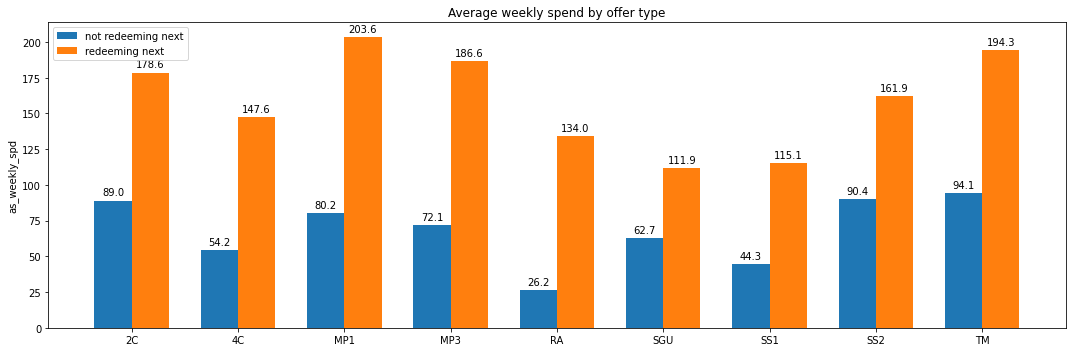

In [20]:
labels = list(df_1['offer_type'].unique())
flag_0 = list(df_1[df_1['next_redeem_flag']==0]['as_weekly_spd'])
flag_1 = list(df_1[df_1['next_redeem_flag']==1]['as_weekly_spd'])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, flag_0, width, label='not redeeming next')
rects2 = ax.bar(x + width/2, flag_1, width, label='redeeming next')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('as_weekly_spd')
ax.set_title('Average weekly spend by offer type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.1f')
ax.bar_label(rects2, padding=3, fmt='%.1f')

fig.tight_layout()

plt.show()